<a href="https://colab.research.google.com/github/ymuto0302/RW2025/blob/main/MLP_pytorch_basic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PyTorch を用いた MLP の実装
(注) PyTorch におけるモデル定義に注目してほしいため，Dataset と Dataloader を使用しない設計としている。

## ライブラリのインポート
PyTorch を利用する場合，`torch`，ネットワーク定義と損失関数定義に用いる `torch.nn`, 最適化アルゴリズムを定義する `torch.optim` をインポートする。

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from sklearn.preprocessing import StandardScaler

## データ生成
PyTorch ではモデルに与えるデータ形式がテンソルであるため，その変換部を実装した。

（注意) MLP ではデータの標準化が推奨されている。本来ならば，訓練データで学習した scaler をテストデータへ適用すべきだが，（ちょっと手を抜いて）訓練・テストへの分割前に標準化を行っている。

In [ ]:
# データの準備: 手書き数字データセット MNIST を用いる
def prepare_data(device='cpu'):
    # 手書き数字データセットの読み込み
    digits = load_digits()
    X, y = digits.data, digits.target

    # データの標準化
    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    # NumPy配列をPyTorchテンソルに変換
    X_tensor = torch.FloatTensor(X).to(device)
    y_tensor = torch.LongTensor(y).to(device)

    # 訓練用とテスト用に分割
    n_train = int(0.8 * len(X)) # 訓練データのサイズ
    X_train = X_tensor[:n_train]
    y_train = y_tensor[:n_train]
    X_test = X_tensor[n_train:]
    y_test = y_tensor[n_train:]

    return X_train, y_train, X_test, y_test

## モデルの定義

In [ ]:
# MLPモデルの定義
class MLP(nn.Module):
    def __init__(self, input_size, output_size):
        super(MLP, self).__init__()

        self.network = nn.Sequential(
            nn.Linear(input_size, 32),
            nn.ReLU(),
            nn.Linear(32,  16),
            nn.ReLU(),
            nn.Linear(16, output_size))

    def forward(self, x):
        return self.network(x)

## モデルの学習

In [ ]:
# モデルを学習するための関数
def train_model(model, X_train, y_train, X_test, y_test, epochs=100, batch_size=32):
    # 損失関数とオプティマイザー
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0001)

    # 学習履歴を保存
    train_losses = []
    test_accuracies = []

    # データサイズとバッチ数
    n_samples = len(X_train) # 訓練サンプル数
    n_batches = (n_samples + batch_size - 1) // batch_size

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0.0

        # ミニバッチ学習      （注)手動でバッチを作成する
        for i in range(n_batches):
            start_idx = i * batch_size
            end_idx = min((i + 1) * batch_size, n_samples)

            # バッチデータの取得
            batch_X = X_train[start_idx:end_idx]
            batch_y = y_train[start_idx:end_idx]

            # 勾配の初期化
            optimizer.zero_grad()

            # 順伝播
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)

            # 逆伝播
            loss.backward()
            optimizer.step()

            # 損失の累積
            epoch_loss += loss.item()

        # エポックごとの平均損失を記録
        avg_loss = epoch_loss / n_batches
        train_losses.append(avg_loss)

        # テストデータでの精度評価
        model.eval()
        with torch.no_grad():
            # 予測
            test_outputs = model(X_test)
            # 確率最大のクラスを取り出す
            _, predicted = torch.max(test_outputs.data, 1)
            # 正解率を求める
            accuracy = (predicted == y_test).float().mean().item()
            # 正解率の累積
            test_accuracies.append(accuracy)

        # 進捗表示
        if (epoch + 1) % 20 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}, Test Accuracy: {accuracy:.4f}')

    return train_losses, test_accuracies

## メイン関数

In [ ]:
# メイン実行部分
if __name__ == "__main__":
    # デバイス設定
    # GPU が利用可能場合，GPU を利用する
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"使用デバイス: {device}")

    # データの準備
    print("データを準備中...")
    X_train, y_train, X_test, y_test = prepare_data(device)
    print(f"訓練データ: {X_train.shape}, テストデータ: {X_test.shape}")

    # モデルの作成
    input_size = X_train.shape[1]  # 特徴量数
    output_size = 10                # クラス数

    model = MLP(input_size, output_size)
    model = model.to(device)
    print(f"\nモデル構造:\n{model}")

    # モデルの学習
    print("\nモデルを学習中...")
    train_losses, test_accuracies = train_model(
        model, X_train, y_train, X_test, y_test,
        epochs=200, batch_size=32
    )

    # 最終的な性能評価
    model.eval()
    with torch.no_grad():
        # 訓練データでの性能
        train_outputs = model(X_train)
        _, train_predicted = torch.max(train_outputs.data, 1)
        train_accuracy = (train_predicted == y_train).float().mean().item()

        # テストデータでの性能
        test_outputs = model(X_test)
        _, test_predicted = torch.max(test_outputs.data, 1)
        test_accuracy = (test_predicted == y_test).float().mean().item()

    print(f"\n最終結果:")
    print(f"訓練データに対する正解率: {train_accuracy:.4f}")
    print(f"テストデータに対する正解率: {test_accuracy:.4f}")

使用デバイス: cpu
データを準備中...
訓練データ: torch.Size([1437, 64]), テストデータ: torch.Size([360, 64])

モデル構造:
MLP(
  (network): Sequential(
    (0): Linear(in_features=64, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=16, bias=True)
    (3): ReLU()
    (4): Linear(in_features=16, out_features=10, bias=True)
  )
)

モデルを学習中...
Epoch [20/200], Loss: 1.2292, Test Accuracy: 0.7111
Epoch [40/200], Loss: 0.5028, Test Accuracy: 0.8056
Epoch [60/200], Loss: 0.2500, Test Accuracy: 0.8528
Epoch [80/200], Loss: 0.1470, Test Accuracy: 0.8667
Epoch [100/200], Loss: 0.0967, Test Accuracy: 0.8806
Epoch [120/200], Loss: 0.0680, Test Accuracy: 0.8861
Epoch [140/200], Loss: 0.0496, Test Accuracy: 0.8833
Epoch [160/200], Loss: 0.0368, Test Accuracy: 0.8833
Epoch [180/200], Loss: 0.0274, Test Accuracy: 0.8889
Epoch [200/200], Loss: 0.0204, Test Accuracy: 0.8972

最終結果:
訓練データに対する正解率: 0.9986
テストデータに対する正解率: 0.8972


## 学習履歴の可視化

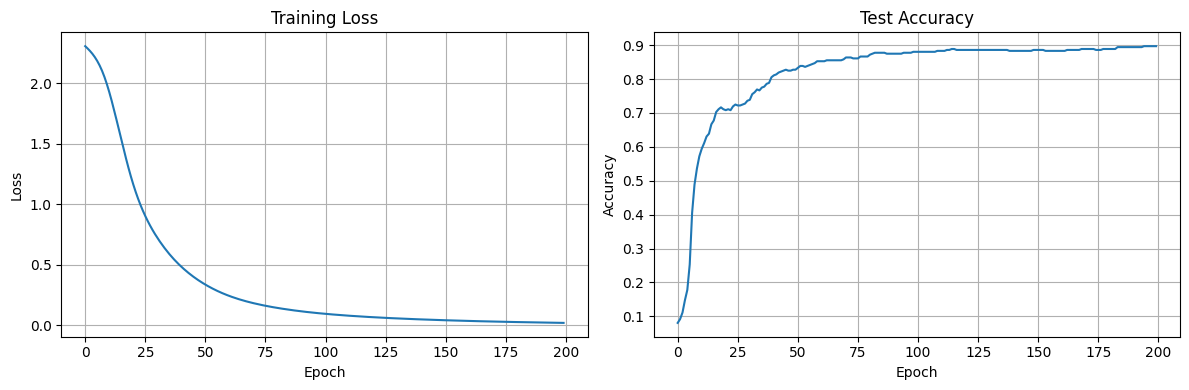

In [ ]:
# 可視化関数
def plot_training_history(train_losses, test_accuracies):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    # 損失の推移
    ax1.plot(train_losses)
    ax1.set_title('Training Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.grid(True)

    # テスト精度の推移
    ax2.plot(test_accuracies)
    ax2.set_title('Test Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

# 学習履歴の可視化
plot_training_history(train_losses, test_accuracies)